In [1]:
%matplotlib inline
import datetime
import pytz
from pyiem.plot import MapPlot, nwssnow
import pandas as pd
import re
import numpy as np
from pyiem import iemre, reference
from pyiem.util import get_dbconn

MAGRE = re.compile("(0\.[0-9][0-9]) INCH")
cmap = nwssnow()
clevs = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

In [2]:
txt = """"""

def get_lsrs(sts, ets):
    ''' Return snowfall lsrs '''
    POSTGIS = get_dbconn('postgis')
    cursor = POSTGIS.cursor()
    data = []
    cursor.execute("""
    SELECT state, max(magnitude) as val, max(remark) as mcomment, ST_x(geom) as lon, ST_y(geom) as lat
    from lsrs WHERE typetext in ('ICE STORM', 'FREEZING RAIN') and 
    valid >= %s and valid < %s and wfo in ('FSD', 'MPX', 'ARX', 'DVN', 'EAX', 'OAX', 'DMX')
    GROUP by state, lon, lat
    """, (sts, ets))
    for i, row in enumerate(cursor):
        magnitude = row[1]
        if magnitude is None:
            t = MAGRE.findall(row[2])
            if len(t) == 0:
                print(row[2])
            else:
                magnitude = float(t[0])
        if magnitude is None:
            continue
        data.append(dict(val=magnitude, comment=row[2], lat=row[4], lon=row[3],
                         label='l%s' % (i,), source='lsr', useme=True))
    
    cursor.close()
    POSTGIS.close()
    return data

sts = datetime.datetime(2019, 2, 5, 18)
sts = sts.replace(tzinfo=pytz.UTC)
ets = datetime.datetime(2019, 2, 6, 18, 0)
ets = ets.replace(tzinfo=pytz.UTC)
lrows = get_lsrs(sts, ets)

df = pd.DataFrame(lrows)
df.sort_values(by='val', ascending=False, inplace=True)

ICE ACCUMULATION 0.2 INCHES. ICE IS MELTING.
ICE ACCUMULATION 0.2 INCHES WITH OCCASIONAL DRIZZLE NOW.
0.1 INCH OF ICE ACCUMULATION FROM FREEZING RAIN.
COMBINED SLEET AND FREEZING RAIN OF 0.5 TO 0.6 INCH.


In [3]:
# Now we filter the DataFrame
radii = [0.6, 0.9, 1.2]  # decimal degrees

df['useme'] = False
newrows = []
for lon in np.arange(reference.IA_WEST, reference.IA_EAST, radii[0]):
    for lat in np.arange(reference.IA_SOUTH, reference.IA_NORTH, radii[0]):
        hit = False
        for radius in radii:
            west = lon - (radius / 2.)
            east = lon + (radius / 2.)
            south = lat - (radius / 2.)
            north = lat + (radius / 2.)
            df2 = df[(df['lat'] >= south) & (df['lat'] < north) &
                     (df['lon'] >= west) & (df['lon'] < east)]
            if len(df2.index) > 0:
                df.at[df2.index, 'useme'] = False
                df.at[df2.index[0], 'useme'] = True
                hit = True
                break
        if not hit:
            newrows.append(dict(val=0, lat=lat, lon=lon, label='i%s' % (len(newrows),), source='int', useme=True))
            continue
if len(newrows) > 0:
    df = df.append(newrows)
df.set_index('label', inplace=True)

/opt/miniconda3/envs/prod/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


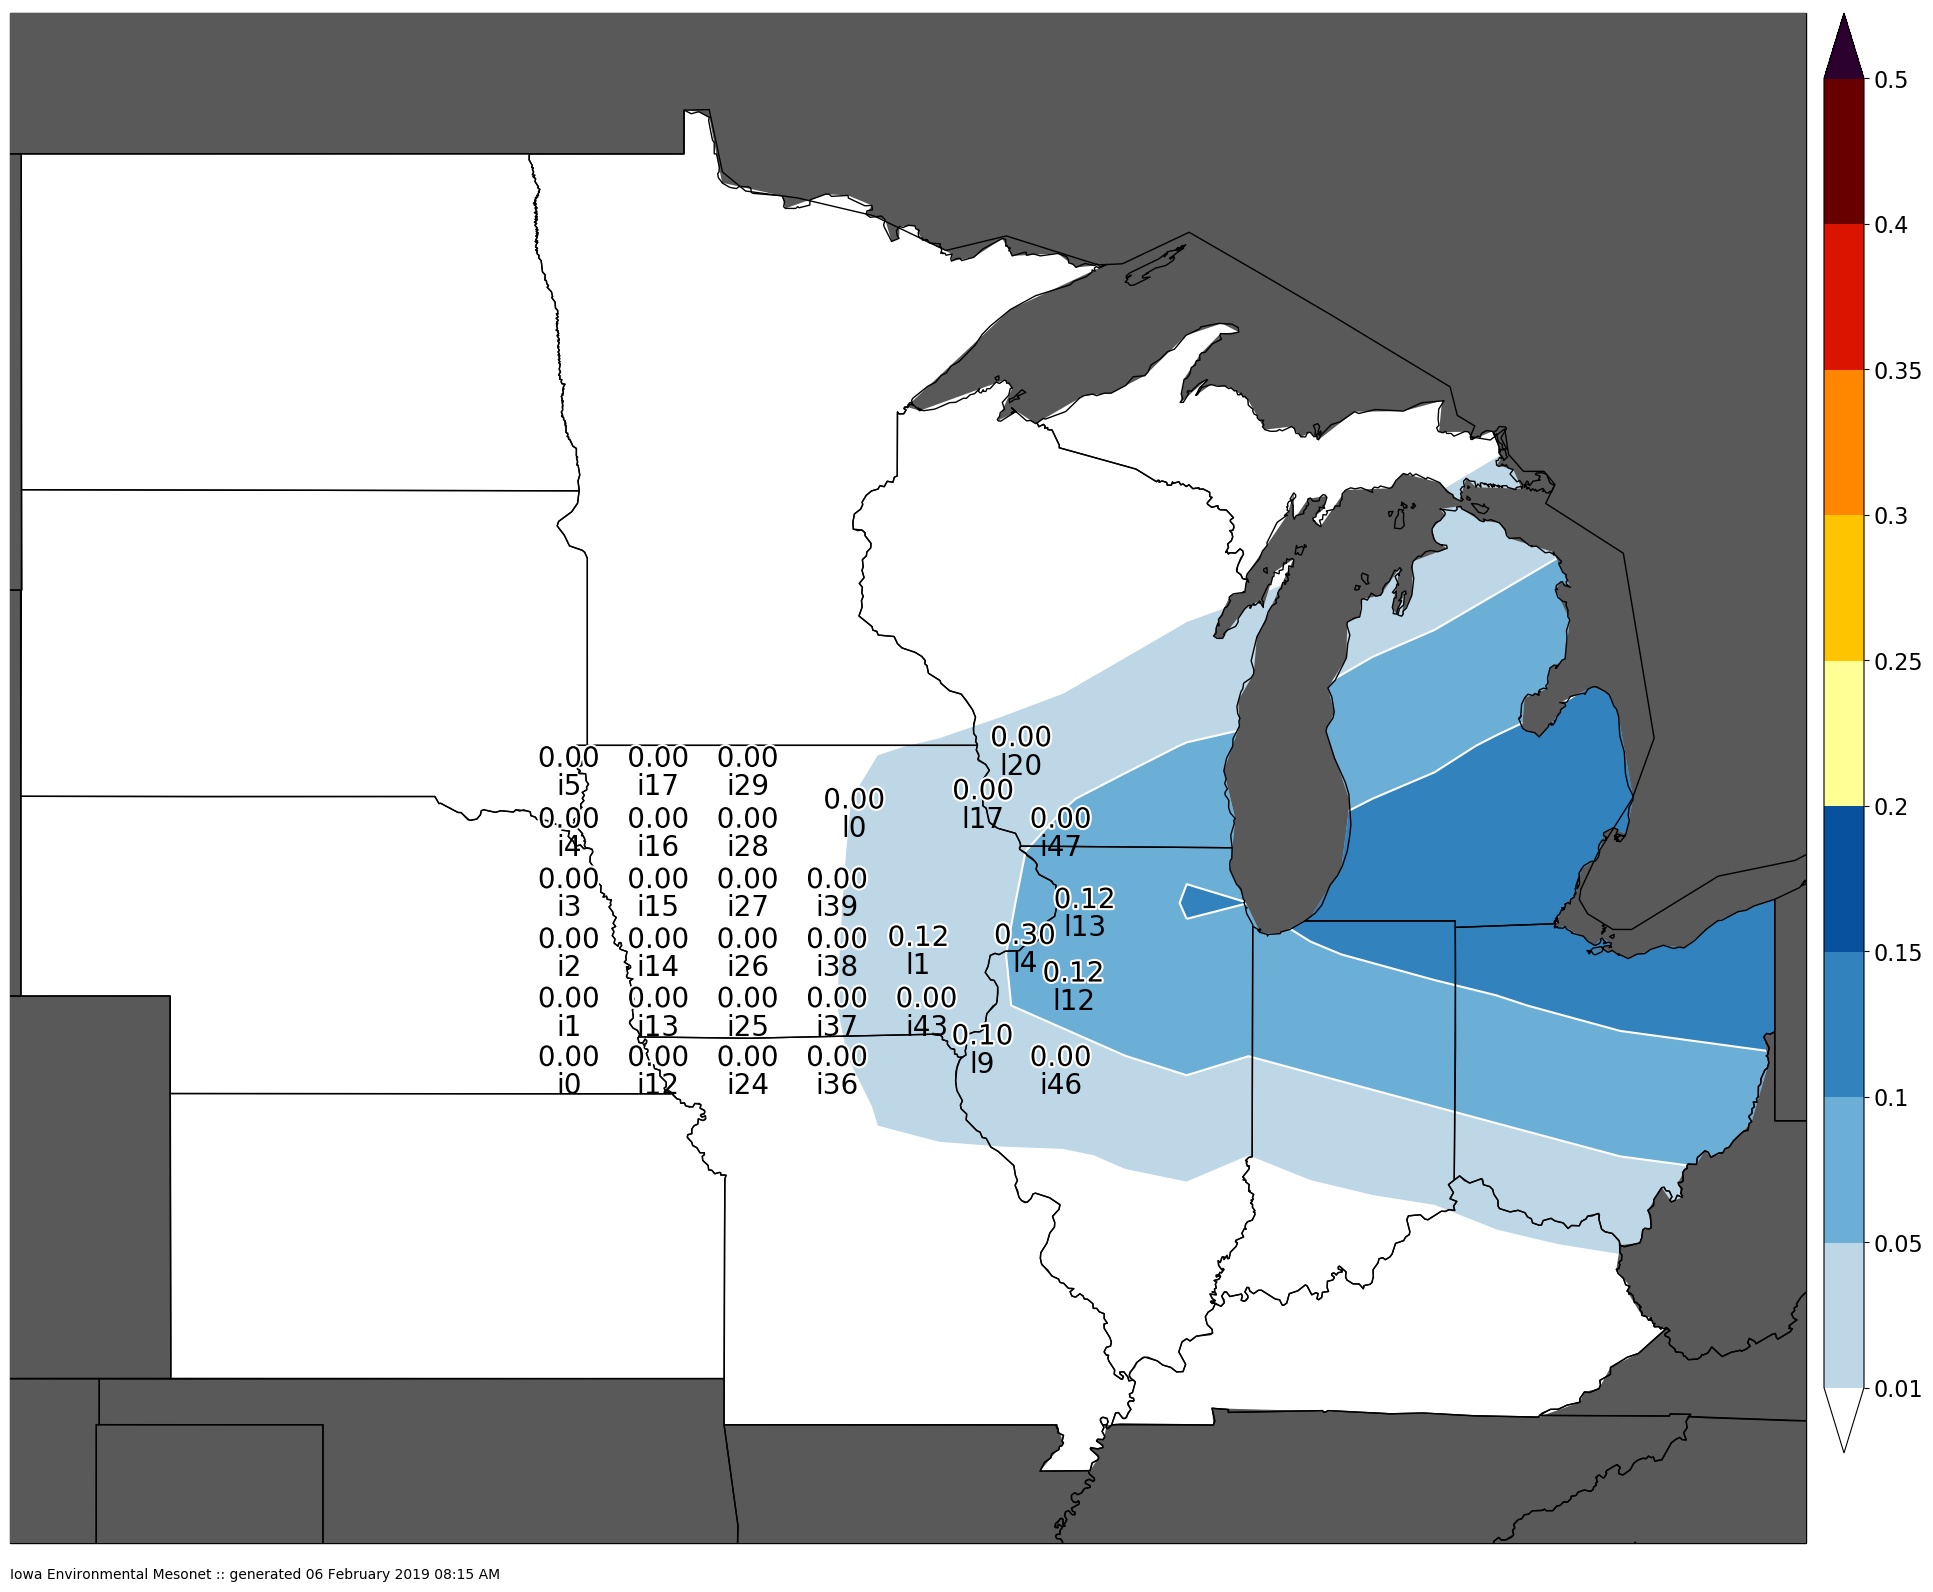

In [4]:
cull = []
if cull:
    df.at[cull, 'useme'] = False


m = MapPlot(figsize=(20,18), sector='midwest')
df2 = df[df.useme]
m.contourf(df2.lon.values, df2.lat.values, df2.val.values, clevs, cmap=cmap)
m.plot_values(df2['lon'], df2['lat'], df2['val'], '%.2f', labels=df2.index.values, textsize=20,
              labeltextsize=20, labelbuffer=5)

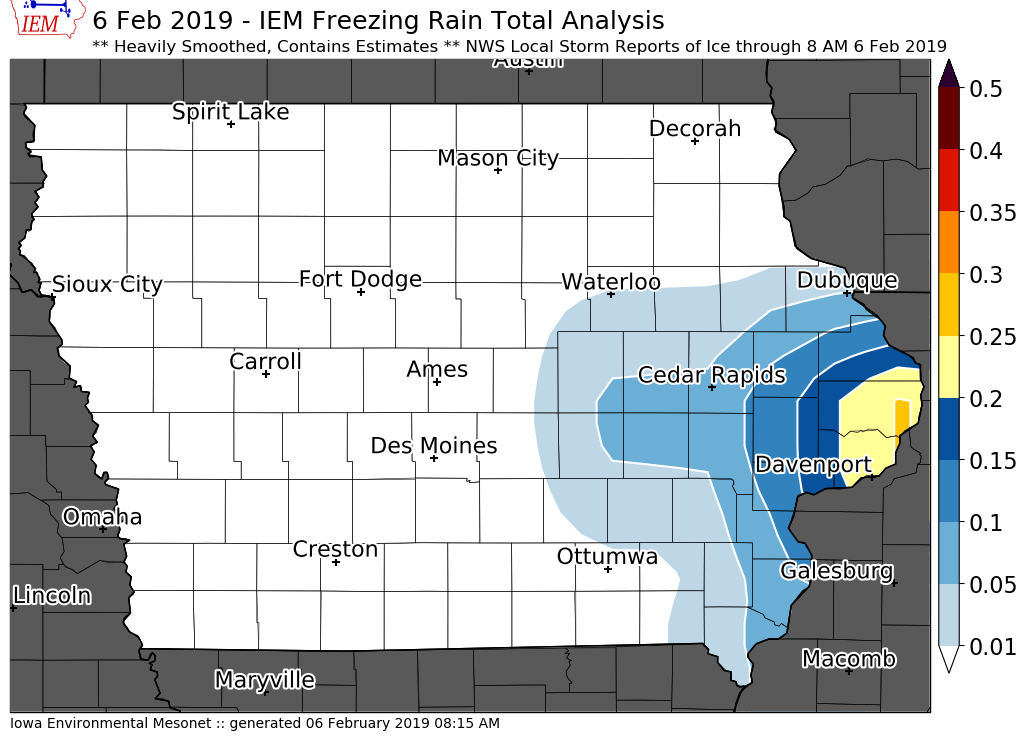

In [5]:
# now we are ready to plot!

m = MapPlot(sector='iowa',
            title='6 Feb 2019 - IEM Freezing Rain Total Analysis',
            subtitle="** Heavily Smoothed, Contains Estimates ** NWS Local Storm Reports of Ice through 8 AM 6 Feb 2019")
m.contourf(df2.lon.values, df2.lat.values, df2.val.values, clevs, cmap=cmap)
#m.plot_values(np.array(df2.lon), np.array(df2.lat), np.array(df2.val), '%.2f')
m.drawcounties()
m.drawcities()
m.postprocess(filename='190206.png')
